<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study3/blob/main/test_0628_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install memory_profiler

In [3]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import time
import psutil
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import keras.backend as K
import h5py
from keras.regularizers import l2
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gc
from memory_profiler import memory_usage

In [4]:
# 시드 설정
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 환경 변수 설정 (결정론적 연산 보장)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_data'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']

# 데이터 로드 및 전처리 함수 정의
def load_data(base_dir, split):
    X = []
    y = []
    split_dir = os.path.join(base_dir, split)
    for category in categories:
        category_dir = os.path.join(split_dir, category)
        for file in os.listdir(category_dir):
            file_path = os.path.join(category_dir, file)
            data = pd.read_csv(file_path, header=None).values
            data = pd.to_numeric(data.flatten(), errors='coerce').reshape(-1, data.shape[1])
            data = np.nan_to_num(data).astype('float32')  # NaN 값을 0으로 대체하고, float32로 변환
            X.append(data)
            y.append(category)
    return np.array(X), np.array(y)

# 데이터 로드
X_train, y_train = load_data(base_dir, 'train')
X_val, y_val = load_data(base_dir, 'validation')
X_test, y_test = load_data(base_dir, 'test')

# 데이터 차원 변경 (CNN 입력 형식에 맞게)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# 원-핫 인코딩
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [6]:
def create_model():
    model = Sequential(name='CNN_Model')
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=(X_train.shape[1], X_train.shape[2]), name='conv1'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool1'))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='conv2'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool2'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.0001), name='dense1'))  # Dense 레이어에 L2 정규화
    model.add(Dropout(0.3, name='dropout'))
    model.add(Dense(len(categories), activation='softmax', name='output'))

    return model

# Create and compile the model
model = create_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Train the model
history = model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_val, y_val_categorical))

Epoch 1/10
219/219 [==============================] - 81s 365ms/step - loss: 1.5083 - accuracy: 0.4840 - val_loss: 1.2044 - val_accuracy: 0.5869
Epoch 2/10
219/219 [==============================] - 79s 361ms/step - loss: 1.0281 - accuracy: 0.5411 - val_loss: 0.4756 - val_accuracy: 0.7347
Epoch 3/10
219/219 [==============================] - 80s 364ms/step - loss: 0.6476 - accuracy: 0.7187 - val_loss: 0.2616 - val_accuracy: 0.9875
Epoch 4/10
219/219 [==============================] - 80s 366ms/step - loss: 0.5867 - accuracy: 0.7287 - val_loss: 0.2967 - val_accuracy: 0.9687
Epoch 5/10
219/219 [==============================] - 81s 372ms/step - loss: 0.5598 - accuracy: 0.7233 - val_loss: 0.2426 - val_accuracy: 0.9687
Epoch 6/10
219/219 [==============================] - 81s 372ms/step - loss: 0.5419 - accuracy: 0.7307 - val_loss: 0.4985 - val_accuracy: 0.7488
Epoch 7/10
219/219 [==============================] - 82s 374ms/step - loss: 0.5428 - accuracy: 0.7290 - val_loss: 0.2232 - val_ac

In [8]:
# 원본 모델 저장
model.save('model.h5')

# 원본 모델 추론 시간 및 메모리 사용량 측정
process = psutil.Process(os.getpid())
memory_usage_before_inference_original = process.memory_info().rss / (1024 * 1024)

start_time = time.time()
y_pred_categorical_original = model.predict(X_test)
end_time = time.time()
inference_time_original = end_time - start_time

memory_usage_after_inference_original = process.memory_info().rss / (1024 * 1024)

print(f"Original Model Memory Usage - Before: {memory_usage_before_inference_original:.2f} MB, After: {memory_usage_after_inference_original:.2f} MB")
print(f"Original Model Inference Time: {inference_time_original:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 3s 71ms/step
Original Model Memory Usage - Before: 5604.29 MB, After: 5777.81 MB
Original Model Inference Time: 3.22 seconds


In [9]:
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)

# 원본 모델 추론 함수
def original_inference():
    return model.predict(X_test)

# 메모리 사용량 측정 함수
def measure_inference_memory_usage(inference_func):
    gc.collect()
    memory_usage_before = get_memory_usage()

    start_time = time.time()
    mem_usage = memory_usage((inference_func,))
    end_time = time.time()

    memory_usage_after = get_memory_usage()

    max_memory_usage_during_inference = max(mem_usage) - memory_usage_before
    inference_time = end_time - start_time

    return memory_usage_before, memory_usage_after, inference_time, max_memory_usage_during_inference

# 원본 모델 저장
model.save('model.h5')

# 원본 모델 추론 시간 및 메모리 사용량 측정
memory_usage_before_inference_original, memory_usage_after_inference_original, inference_time_original, max_memory_usage_during_inference_original = measure_inference_memory_usage(original_inference)

print(f"Original Model Memory Usage - Before: {memory_usage_before_inference_original:.2f} MB, After: {memory_usage_after_inference_original:.2f} MB")
print(f"Original Model Inference Time: {inference_time_original:.2f} seconds")
print(f"Original Model Max Memory Usage During Inference: {max_memory_usage_during_inference_original:.2f} MB")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


40/40 [==============================] - 5s 110ms/step
Original Model Memory Usage - Before: 4902.49 MB, After: 5053.90 MB
Original Model Inference Time: 5.10 seconds
Original Model Max Memory Usage During Inference: 284.52 MB


In [10]:
# 원본 모델 추론 시간 및 메모리 사용량 측정
process = psutil.Process(os.getpid())
memory_usage_before_inference_original = process.memory_info().rss / (1024 * 1024)

start_time = time.time()
y_pred_categorical_original = model.predict(X_test)
end_time = time.time()
inference_time_original = end_time - start_time

memory_usage_after_inference_original = process.memory_info().rss / (1024 * 1024)
memory_usage_diff = memory_usage_after_inference_original - memory_usage_before_inference_original

print(f"Original Model Memory Usage: {memory_usage_diff:.2f} MB")
print(f"Original Model Inference Time: {inference_time_original:.2f} seconds")

40/40 [==============================] - 3s 73ms/step
Original Model Memory Usage: 132.92 MB
Original Model Inference Time: 3.24 seconds


In [11]:
# 모델 사이즈 측정
model_size = os.path.getsize('model.h5') / (1024 * 1024)
print(f"Model Size: {model_size:.2f} MB")

Model Size: 439.50 MB


In [12]:
# 검증 데이터 평가
val_loss, val_accuracy = model.evaluate(X_val, y_val_categorical)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

40/40 [==============================] - 3s 73ms/step - loss: 0.1372 - accuracy: 0.9710
Validation Loss: 0.1372
Validation Accuracy: 0.9710


In [13]:
# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

40/40 [==============================] - 3s 72ms/step - loss: 0.1346 - accuracy: 0.9734
Test Loss: 0.1346
Test Accuracy: 0.9734


In [14]:
# 혼동 행렬 및 성능 지표 출력 (테스트 데이터)
y_pred = np.argmax(y_pred_categorical_original, axis=1)
conf_matrix_test = confusion_matrix(y_test_encoded, y_pred)
class_report_test = classification_report(y_test_encoded, y_pred, target_names=categories)
f1_score_original = f1_score(y_test_encoded, y_pred, average='weighted')

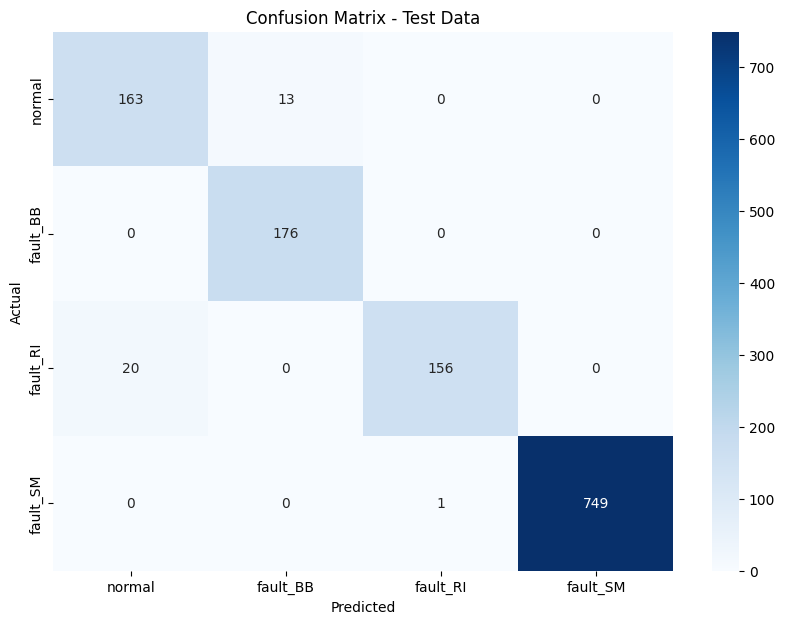

In [15]:
# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.show()


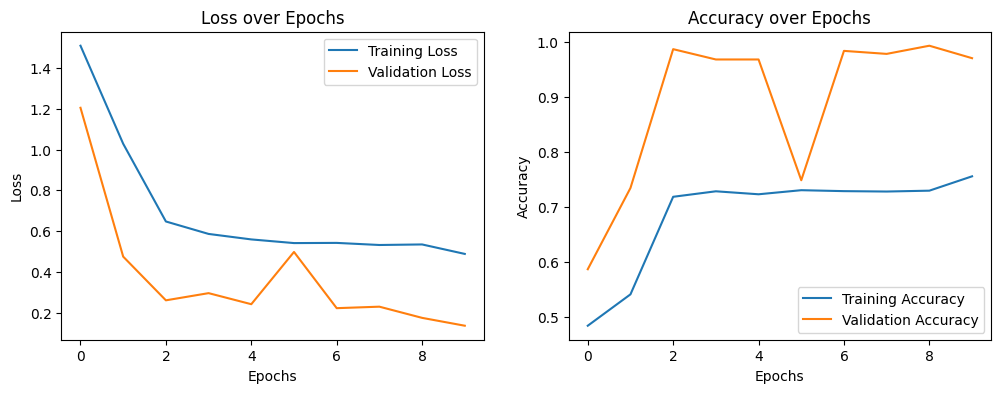

In [16]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

In [17]:
# 성능 비교 출력
performance_comparison = {
    'Metric': ['Model Size (MB)', 'Original Memory Usage (MB)', 'Original Inference Time (s)', 'Validation Loss', 'Validation Accuracy', 'Test Loss', 'Test Accuracy', 'F1 Score'],
    'Values': [os.path.getsize('model.h5') / (1024 * 1024), memory_usage_after_inference_original, inference_time_original, val_loss, val_accuracy, test_loss, test_accuracy, f1_score_original]
}

performance_df = pd.DataFrame(performance_comparison)
print("\nPerformance Comparison:")
print(performance_df)


Performance Comparison:
                        Metric       Values
0              Model Size (MB)   439.496780
1   Original Memory Usage (MB)  5186.820312
2  Original Inference Time (s)     3.237251
3              Validation Loss     0.137212
4          Validation Accuracy     0.971049
5                    Test Loss     0.134630
6                Test Accuracy     0.973396
7                     F1 Score     0.973360


In [18]:
# 성능 보고서 출력
print("\nClassification Report:")
print(class_report_test)


Classification Report:
              precision    recall  f1-score   support

      normal       0.89      0.93      0.91       176
    fault_BB       0.93      1.00      0.96       176
    fault_RI       0.99      0.89      0.94       176
    fault_SM       1.00      1.00      1.00       750

    accuracy                           0.97      1278
   macro avg       0.95      0.95      0.95      1278
weighted avg       0.97      0.97      0.97      1278

